## Import libraries and USE GPU

In [30]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import numpy as np
import pathlib

# Using GPU
import os
import scipy.io as scpy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## Prepare Dataset

In [31]:
# Load .mat data, will be loaded as dictionary object so you need to extract values from it.
data = scpy.loadmat("matlab15000.mat")
# Extracting x_train from the mat file dictionary.
x_data = data["XTrain"]
# Extracting y_train from the mat file dictionary.
y_data = data["unnamed"]
# Converting x_train and y_train to a numpy array.
x_data = np.array(x_data,dtype='float32')
y_train = np.array(y_data,dtype='float32')
# Verifying the shapes.
print(x_data.shape)
print(y_data.shape)

SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# split into train test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=SEED)
######################################################################################################

(15000, 1000)
(15000, 1)


### Split dataset into train, test and validation.

In [32]:
x_val = x_test[:1500]
y_val = y_test[:1500]
x_test_to_use = x_test[1500:]
y_test_to_use = y_test[1500:]

### Check dimension of train, test and validation dataset.

In [33]:
len(x_train), len(x_val), len(x_test_to_use)

(12000, 1500, 1500)

### Define Convolutional Model as Described in the Paper

Model: "conv_model_paper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 994, 32)           256       
                                                                 
 batch_normalization_14 (Bat  (None, 994, 32)          128       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 994, 32)           0         
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 124, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 120, 48)           7728      
                                                                 
 batch_normalization_15 (Bat  (None, 120, 48)     

/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


375/375 [==============================] - 1s 2ms/step - loss: 1.0789 - accuracy: 0.6097 - val_loss: 0.5444 - val_accuracy: 0.7933
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 0.6366 - accuracy: 0.7433 - val_loss: 0.3893 - val_accuracy: 0.8467
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.5068 - accuracy: 0.7948 - val_loss: 0.3290 - val_accuracy: 0.8773
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 0.4446 - accuracy: 0.8249 - val_loss: 0.2942 - val_accuracy: 0.9007
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 0.4042 - accuracy: 0.8472 - val_loss: 0.2731 - val_accuracy: 0.9107
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3713 - accuracy: 0.8598 - val_loss: 0.2504 - val_accuracy: 0.9180
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3472 - accuracy: 0.8716 - val_loss: 0.2296 - val_accuracy: 0.9220
Epoch 8/100

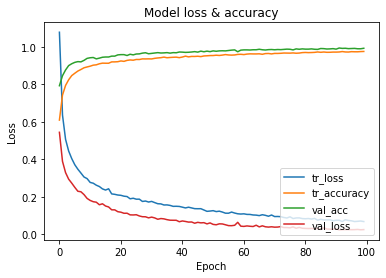

In [34]:
import tensorflow_model_optimization as tfmot

model = tf.keras.Sequential(name='conv_model_paper')
model.add(tf.keras.layers.InputLayer(input_shape=(1000,1)))
model.add(tf.keras.layers.Conv1D(32,7))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=8))
model.add(tf.keras.layers.Conv1D(48,5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

print(model.summary())
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

## Save the model without optimization and convert it to tflite format

In [35]:
SAVED_MODEL = 'models/'
tf.saved_model.save(model, SAVED_MODEL)
float_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
float_tflite_model = float_converter.convert()
import pathlib
tflite_model_file = pathlib.Path('conv_model_paper.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
2022-10-05 14:31:26.555448: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-05 14:31:26.555466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-05 14:31:26.555553: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models/
2022-10-05 14:31:26.557255: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-05 14:31:26.557267: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: models/
2022-10-05 14:31:26.562441: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-05 14:31:26.607030: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: models/
2022-10-05 14:31:26.618083: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: suc

88312

## Quantize same model and save it in tflite format.

In [36]:
quantized_model = tfmot.quantization.keras.quantize_model(model)
SAVED_MODEL = 'models/'
tf.saved_model.save(model, SAVED_MODEL)
float_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
float_tflite_model = float_converter.convert()
import pathlib
tflite_model_file = pathlib.Path('conv_model_paper_quantized.tflite')
tflite_model_file.write_bytes(float_tflite_model)


RuntimeError: Layer conv1d_8:<class 'keras.layers.convolutional.conv1d.Conv1D'> is not supported. You can quantize this layer by passing a `tfmot.quantization.keras.QuantizeConfig` instance to the `quantize_annotate_layer` API.

## Change the model described in the paper to make it suitable for conversion to TFLite, and quantization.

Model: "conv_modified_conv_model_paper_paper_2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reshape (Reshape)           (None, 1000, 1, 1)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 1000, 1, 32)       1600      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 125, 1, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 1, 48)        38448     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 1, 48)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_17 (MaxPooli

/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


375/375 [==============================] - 2s 4ms/step - loss: 0.7855 - accuracy: 0.6507 - val_loss: 0.5458 - val_accuracy: 0.7800
Epoch 2/100
375/375 [==============================] - 1s 4ms/step - loss: 0.4421 - accuracy: 0.8374 - val_loss: 0.3858 - val_accuracy: 0.8520
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3336 - accuracy: 0.8956 - val_loss: 0.3229 - val_accuracy: 0.8893
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2737 - accuracy: 0.9178 - val_loss: 0.2566 - val_accuracy: 0.9147
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 0.2326 - accuracy: 0.9310 - val_loss: 0.2132 - val_accuracy: 0.9333
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 0.2019 - accuracy: 0.9397 - val_loss: 0.1852 - val_accuracy: 0.9427
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1791 - accuracy: 0.9438 - val_loss: 0.1601 - val_accuracy: 0.9467
Epoch 8/100

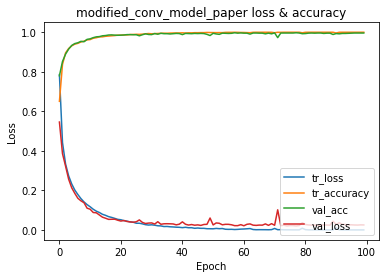

In [37]:
from genericpath import samefile
import tensorflow_model_optimization as tfmot

modified_conv_model_paper = tf.keras.Sequential(name='conv_modified_conv_model_paper_paper_2D')
modified_conv_model_paper.add(tf.keras.layers.Reshape((1000,1,1),name='Reshape', input_shape=(1000,)))
modified_conv_model_paper.add(tf.keras.layers.Conv2D(32,7,padding='same',activation='relu'))
modified_conv_model_paper.add(tf.keras.layers.MaxPooling2D(8,8,padding='same'))
modified_conv_model_paper.add(tf.keras.layers.Conv2D(48,5,padding='same',activation='relu'))
modified_conv_model_paper.add(tf.keras.layers.MaxPooling2D(4,4,padding='same'))
modified_conv_model_paper.add(tf.keras.layers.MaxPooling2D(4,4,padding='same'))
modified_conv_model_paper.add(tf.keras.layers.Flatten())
modified_conv_model_paper.add(tf.keras.layers.Dense(32))
modified_conv_model_paper.add(tf.keras.layers.Dense(32))
modified_conv_model_paper.add(tf.keras.layers.Dense(3, activation='softmax'))


print(modified_conv_model_paper.summary())
modified_conv_model_paper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = modified_conv_model_paper.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('modified_conv_model_paper loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating modified_conv_model_paper
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

## Save model as .tflite and .pb

In [38]:
SAVED_MODEL = 'models/modified_conv_model_paper'
tf.saved_model.save(modified_conv_model_paper, SAVED_MODEL)
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
modidified_conv_model_converted = converter.convert()
import pathlib
tflite_model_file = pathlib.Path('conv_model_paper_2D.tflite')
tflite_model_file.write_bytes(modidified_conv_model_converted)

INFO:tensorflow:Assets written to: models/modified_conv_model_paper/assets


INFO:tensorflow:Assets written to: models/modified_conv_model_paper/assets
2022-10-05 14:36:37.560649: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-05 14:36:37.560665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-05 14:36:37.560740: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models/modified_conv_model_paper
2022-10-05 14:36:37.561617: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-05 14:36:37.561630: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: models/modified_conv_model_paper
2022-10-05 14:36:37.563944: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-05 14:36:37.592079: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: models/modified_conv_model_paper
2022-10-05 14:36:

219992

## Quantize same model and save it.

In [42]:
SAVED_MODEL = 'models/modified_conv_model_paper'
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_file = pathlib.Path('conv_model_paper_2D_quantized.tflite')
tflite_model_file.write_bytes(tflite_quant_model)

2022-10-05 14:45:00.926486: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-05 14:45:00.926504: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-05 14:45:00.926583: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models/modified_conv_model_paper
2022-10-05 14:45:00.927504: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-05 14:45:00.927516: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: models/modified_conv_model_paper
2022-10-05 14:45:00.930105: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-05 14:45:00.959901: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: models/modified_conv_model_paper
2022-10-05 14:45:00.966900: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for t

61280

## Define experimantal random 2D convolutional model.

Model: "custom_2D_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reshape (Reshape)           (None, 1000, 1, 1)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 1000, 1, 8)        208       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 500, 1, 8)        0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 4000)              0         
                                                                 
 output (Dense)              (None, 3)                 12003     
                                                                 
Total params: 12,211
Trainable params: 12,211
Non-trainable params: 0
__________________________________________

/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


375/375 [==============================] - 1s 3ms/step - loss: 0.8108 - accuracy: 0.6982 - val_loss: 0.5651 - val_accuracy: 0.8360
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4313 - accuracy: 0.8749 - val_loss: 0.3283 - val_accuracy: 0.9040
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2785 - accuracy: 0.9178 - val_loss: 0.2398 - val_accuracy: 0.9180
Epoch 4/100
375/375 [==============================] - 1s 1ms/step - loss: 0.2127 - accuracy: 0.9351 - val_loss: 0.1949 - val_accuracy: 0.9347
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1757 - accuracy: 0.9479 - val_loss: 0.1678 - val_accuracy: 0.9433
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1500 - accuracy: 0.9541 - val_loss: 0.1441 - val_accuracy: 0.9533
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1304 - accuracy: 0.9597 - val_loss: 0.1308 - val_accuracy: 0.9600
Epoch 8/100

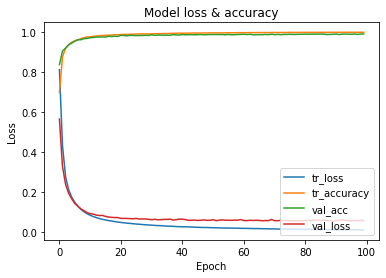

In [43]:
my_custom_model = tf.keras.Sequential(name='custom_2D_conv_model')
my_custom_model.add(tf.keras.Input(shape=(x_train.shape[1],)))
my_custom_model.add(tf.keras.layers.Reshape((1000,1,1),name='Reshape'))
my_custom_model.add(tf.keras.layers.Conv2D(8,5,padding='same',activation='relu'))
my_custom_model.add(tf.keras.layers.MaxPooling2D(2,2, padding='same'))
my_custom_model.add(tf.keras.layers.Flatten())
my_custom_model.add(tf.keras.layers.Dense(3,activation='softmax', name="output"))


print(my_custom_model.summary())
my_custom_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = my_custom_model.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

## Save custom model as .tflite and .pb

In [44]:
SAVED_MODEL = 'my_custom_model/'
tf.saved_model.save(my_custom_model, SAVED_MODEL)
float_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
float_tflite_model = float_converter.convert()
tflite_model_file = pathlib.Path('my_custom_model.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: my_custom_model/assets


INFO:tensorflow:Assets written to: my_custom_model/assets
2022-10-05 14:47:57.770199: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-05 14:47:57.770216: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-05 14:47:57.770291: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: my_custom_model/


52436

2022-10-05 14:47:57.770988: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-05 14:47:57.771000: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: my_custom_model/
2022-10-05 14:47:57.772797: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-05 14:47:57.787979: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: my_custom_model/
2022-10-05 14:47:57.792075: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 21784 microseconds.


## Quantize custom model and save it.

In [45]:

converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_file = pathlib.Path('my_custom_model_optimized.tflite')
tflite_model_file.write_bytes(tflite_quant_model)

2022-10-05 14:48:01.803145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-05 14:48:01.803164: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-05 14:48:01.803246: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: my_custom_model/
2022-10-05 14:48:01.803926: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-05 14:48:01.803938: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: my_custom_model/
2022-10-05 14:48:01.805764: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-05 14:48:01.821425: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: my_custom_model/
2022-10-05 14:48:01.825737: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 22489 m

16520

## Define Dense model.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 1000)              0         
                                                                 
 dense_49 (Dense)            (None, 4)                 4004      
                                                                 
 dense_50 (Dense)            (None, 3)                 15        
                                                                 
Total params: 4,019
Trainable params: 4,019
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
  1/188 [..............................] - ETA: 30s - loss: 1.1205 - accuracy: 0.3594

/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


188/188 [==============================] - 1s 3ms/step - loss: 0.7512 - accuracy: 0.6669 - val_loss: 0.5685 - val_accuracy: 0.7980
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 0.5135 - accuracy: 0.8393 - val_loss: 0.4341 - val_accuracy: 0.8720
Epoch 3/100
188/188 [==============================] - 1s 3ms/step - loss: 0.3804 - accuracy: 0.8959 - val_loss: 0.3243 - val_accuracy: 0.9107
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 0.2878 - accuracy: 0.9284 - val_loss: 0.2577 - val_accuracy: 0.9280
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 0.2318 - accuracy: 0.9421 - val_loss: 0.2187 - val_accuracy: 0.9407
Epoch 6/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1935 - accuracy: 0.9528 - val_loss: 0.1863 - val_accuracy: 0.9467
Epoch 7/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 0.9601 - val_loss: 0.1728 - val_accuracy: 0.9520
Epoch 8/100

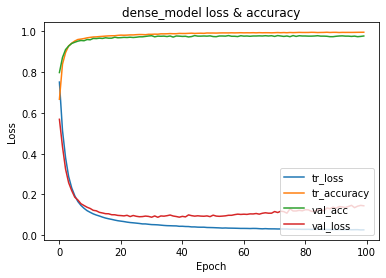

In [46]:
SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
# train_dataset.unbatch()

dense_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1000,)),
    tf.keras.layers.Dense(4, activation='swish'),
    tf.keras.layers.Dense(3,activation='softmax')
])

dense_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
dense_model.summary()              

history=dense_model.fit(train_dataset,validation_data=val_dataset, epochs=100)
# dense_model.evaluate(val_dataset)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('dense_model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating dense_model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

## Save dense model as tflite - no optimization.

In [47]:
SAVED_MODEL = 'dense_model/'
tf.saved_model.save(dense_model, SAVED_MODEL)
float_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
float_tflite_model = float_converter.convert()
import pathlib
tflite_model_file = pathlib.Path('dense_model.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: dense_model/assets


INFO:tensorflow:Assets written to: dense_model/assets
2022-10-05 14:50:24.003465: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-05 14:50:24.003481: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-05 14:50:24.003557: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: dense_model/
2022-10-05 14:50:24.004204: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-05 14:50:24.004215: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: dense_model/
2022-10-05 14:50:24.005970: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-05 14:50:24.020793: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: dense_model/
2022-10-05 14:50:24.024649: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { 

18412

## Quantize dense model and save it as tflite.

In [48]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_file = pathlib.Path('dense_model_optimized.tflite')
tflite_model_file.write_bytes(tflite_quant_model)


2022-10-05 14:50:40.147902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-05 14:50:40.147920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-05 14:50:40.147996: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: dense_model/
2022-10-05 14:50:40.148640: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-05 14:50:40.148652: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: dense_model/
2022-10-05 14:50:40.150423: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-05 14:50:40.165601: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: dense_model/
2022-10-05 14:50:40.170477: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 22481 microseconds.

6496

In [49]:
interpreter = tf.lite.Interpreter(model_path='dense_model.tflite')
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [51]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, indices):
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = 0
  for i, index in enumerate(indices):
    test_data = x_test_to_use[index]
    test_data=np.expand_dims(test_data, axis=0)
    test_labels = y_train[index]

    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    print(output[0])
    print(output[1])
    print(output[2])
    predictions = output.argmax()

  return predictions

In [54]:
import matplotlib.pylab as plt
tflite_model_file = 'dense_model.tflite'
# Change this to test a different image
indice = 333

## Helper function to test the models on one image
def test_model(tflite_file, indice, model_type):

  predictions = run_tflite_model(tflite_file, [indice])

  print(f" Model \n True:{y_test_to_use[indice]}, Predicted:{predictions}")
  
test_model(tflite_model_file, indice, model_type="Float")

8.739755e-08
0.0001626227
0.9998373
 Model 
 True:[2], Predicted:2


In [ ]:
x_test[123]

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path='float_model.tflite')

In [56]:
import numpy as np

def run_tflite_model_for_eval(interpreter, indices):
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = 0
  for i, index in enumerate(indices):
    test_data = x_test_to_use[index]
    test_data=np.expand_dims(test_data, axis=0)

    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    predictions = output.argmax()
  return predictions
  
def evaluate_model(interpreter):
  output_predictions =[]
  for i in range(len(x_test_to_use)):
    output_predictions.append(run_tflite_model_for_eval(interpreter,[i]))
  output_predictions = np.array(output_predictions)
  output_predictions = np.expand_dims(output_predictions, axis=1)
  accuracy = (output_predictions == y_test_to_use).mean()
  return accuracy

In [68]:
interpreter = tf.lite.Interpreter(model_path='conv_model_paper_2D.tflite')
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Optimized dense_model TFLite test_accuracy:', test_accuracy)
# print('Quant TF test accuracy:', q_aware_model_accuracy)

Optimized dense_model TFLite test_accuracy: 0.9926666666666667


### Model with annotated layers for quantization -- Trial can be skipped.

In [ ]:
# ### Quantization based training
# import tensorflow_model_optimization as tfmot
# quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer

# model = tf.keras.Sequential([
# #### tf.keras.layers :

# quantize_annotate_layer((tf.keras.layers.Reshape((1000,1,1),name='Reshape', input_shape=(1000,)))),
# quantize_annotate_layer(tf.keras.layers.Conv2D(16,7,padding='same')),
# quantize_annotate_layer(tf.keras.layers.Activation('relu')),
# quantize_annotate_layer(tf.keras.layers.MaxPooling2D(4,4,padding='same')),
# quantize_annotate_layer(tf.keras.layers.Conv2D(8,5, padding='same')),
# quantize_annotate_layer(tf.keras.layers.Activation('relu')),
# quantize_annotate_layer(tf.keras.layers.MaxPooling2D(4,4,padding='same')),
# quantize_annotate_layer(tf.keras.layers.MaxPooling2D(2,2,padding='same')),
# quantize_annotate_layer(tf.keras.layers.Flatten()),
# quantize_annotate_layer(tf.keras.layers.Dense(32)),
# quantize_annotate_layer(tf.keras.layers.Dense(3, activation='softmax')),
# ])
# quantized_model = tfmot.quantization.keras.quantize_apply(model)
# # quant_aware_model = tfmot.quantization.keras.quantize_model(base_model)
# # quant_aware_model.summary()
# print(model.summary())
# quantized_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = quantized_model.fit(x_train, y_train ,epochs=50, validation_data=(x_test, y_test), verbose=1)   


# # Plotting accuracy and loss
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_loss'])


# plt.title('Model loss & accuracy')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# # accuracy!
# print("Training results")
# print(f"Accuracy: {history.history['accuracy'][-1]}")
# print(f"Loss: {history.history['loss'][-1]}")

# # evaluating model
# print("Evaluation results")
# print(f"Accuracy: {history.history['val_accuracy'][-1]}")
# print(f"Loss: {history.history['val_loss'][-1]}")


# plt.show()